In [2]:
from copy import deepcopy
import geopandas as gpd
import pandas as pd
import ckanapi
import petk
from time import sleep
from tqdm import tqdm_notebook as tqdm
from shapely.geometry import mapping, shape
import json
import re
from sklearn.preprocessing import MinMaxScaler
# import plotly
# import plotly.graph_objs as go
import datetime
import numpy as np
# plotly.offline.init_notebook_mode(connected=False)
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet

[nltk_data] Downloading package wordnet to /home/dottyz/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Open Data "Magic Score" Calculator | POC

**Goal**: for the next Working Group, have a working POC and present the factors contributing to the score to align on weights.

## Planning

### Assumptions/Scope

1. Data will be in CKAN datastore
1. Score will be calculated from CKAN
1. Results will be written back into CKAN
1. Datasets will have only 1 resource ???
1. Factors that can be automated will come from DVT/PETK
1. Factor weighting will begin with even weights

### Logic/Components

1. Read Package Metadata from CKAN
1. Filter packages without resources in datastore (data only, readmes do not count)
1. Loop through resulting packages and measure factor metrics ([more details](https://docs.google.com/spreadsheets/d/1VYlu6KDPoj69Q6DKO8-lFjl9QLRxQ8hSqfQFnjNDTvI/edit#gid=0))
  * PETK
  * Metadata completion

## Read Package Metadata

In [4]:
ckan = ckanapi.RemoteCKAN( address='https://ckan0.cf.opendata.inter.prod-toronto.ca')
packages = ckan.action.package_search(rows=10000)['results']

## Filter Packages

In [5]:
datastore_packages = []

for package in deepcopy(packages):
    if ('test' not in package['name']) and ('travel-time' not in package['name']):
        resources = [ r for r in package['resources'] if (r['datastore_active']) and ('readme' not in r['name'].replace('-', '')) ] 

        if resources:
            package['resources'] = resources
            datastore_packages.append(package)

## Get data from CKAN

In [10]:
%%time

data = {}

for package in datastore_packages:
    data[package['name']] = []
    for resource in package['resources']:
        resource = deepcopy(resource)
        resp = ckan.action.datastore_search(id=resource['id'], limit=1000000000000)

        columns = pd.DataFrame(resp['fields'])['id'].values
        if 'geometry' not in columns:
            df = pd.DataFrame(resp['records'])
        else:
            for i, x in enumerate(resp['records']):
                resp['records'][i]['geometry'] = shape(json.loads(x['geometry']))

            df = gpd.GeoDataFrame(resp['records'])
            df.crs = {'init': 'epsg:4326'}
            
        resource.update({'response': resp, 'df': df, 'name': resource['name']})
        data[package['name']].append(resource)

        sleep(1)

CPU times: user 19.9 s, sys: 7.05 s, total: 26.9 s
Wall time: 4min 38s


## Measure factor metrics

### Check Dataset Metadata

Completion first, then some estimate for relevance
- Description => notes
- Collection Method => collection_method
- Limitations => limitations
- Column schema (descriptions, types, values for missing, valid values)
- Contact of publisher => owner_email
- Keywords => tags, topics

### Check PETK measures

- Constant values
- Geo: Valid geometry
- Column types
- Shape (e.g. long)
- Geo: slivers
- % missing
- Column schema

In [13]:
%%time

metadata_fields = ['notes', 'collection_method', 'limitations', 'owner_email', 'topics']
results = []

for package in datastore_packages:
    filled_count = 0
    for field in metadata_fields:
        filled_count += 1 if field in package.keys() and field is not None and field != '' else 0
    
    for resource in data[package['name']]:
        report = petk.DataReport(resource['df'])
        intro = report.introduce().loc['observations']
        desc = report.describe().T

        fields_with_meaning, fields_with_description = 0, 0
        for f in [ f for f in resource['response']['fields'] if f['id'] != '_id']:
            fields_with_description =+ 1 if ('info' in f) and (f['info']['notes']) else 0
            
            split_name = [x.replace('_', '').strip() for x in re.findall('.+?(?:(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])|(?=[_\s-])|$)', f['id'])]
            english_words = [int(not not wordnet.synsets(sub)) for sub in split_name]
            fields_with_meaning += 1 if (sum(english_words) / len(english_words) >= 0.8) else 0

        results.append({
            'dataset_name': package['name'],
            'resource_name': resource['name'],
            'dataset_metadata_filled_percent': filled_count/len(metadata_fields),
            'completeness_percent': 1 - (intro.loc['missing'][0] / intro.loc['total'][0]),
            'column_descriptions_percent': 1 - (fields_with_description / len(resource['response']['fields'])),
            'meaningful_column_names_percent': 1 - (fields_with_meaning / len(resource['response']['fields'])),
            'no_constant_columns_percent': 1 - (desc[desc['distinct_count'] == 1].shape[0] / desc.shape[0]),
        })

CPU times: user 33.3 s, sys: 0 ns, total: 33.3 s
Wall time: 27.1 s


## Aggregate metrics to dimensions

In [14]:
dimension_results = []

mappings = {
    'metadata': ['dataset_metadata_filled_percent', 'column_descriptions_percent'],
    'completeness': ['completeness_percent'],
    'usability': ['meaningful_column_names_percent', 'no_constant_columns_percent']
}

all_metrics = [ item for sublist in  list(mappings.values()) for item in sublist ]

for i in results:
    row = { k:v for (k, v) in i.items() if k not in all_metrics }
    for m, k in mappings.items():
        scores = [ i[x] for x in k ]
        row[m] = sum(scores)/len(scores)
    dimension_results.append(row)
    
results_df = pd.DataFrame(dimension_results).set_index(['dataset_name', 'resource_name']).round(2)  * 100
results_df.sample(3)

,,completeness,metadata,usability
dataset_name,resource_name,,,
traffic-signals-tabular,traffic-signals-all-version-2-csv,81.0,80.0,63.0
council-and-standing-committee-meeting-statistics,council-and-standing-committee-meeting-statistics-data-2014-2018,100.0,80.0,75.0
building-permits-signs,Building Permits - Signs Data,95.0,80.0,63.0


### Perform MCDM (Multi-Criteria Decision-Making) Analysis

In [7]:
# LEGACY code - from before metrics were aggregated to dimension level
# results_df = pd.DataFrame(results).set_index(['dataset_name', 'resource_name']).round(2)  * 100
# results_df.sample(3)

In [15]:
# LEGACY code - from before metrics were aggregated to dimension level
# criteria = {
#     1: {"name": "meaningful_column_names_percent",},
#     2: {"name": "no_constant_columns_percent",},
#     3: {"name": "completeness_percent",},
#     4: {"name": "dataset_metadata_filled_percent",},
#     5: {"name": "column_descriptions_percent"},
# }

# this is a random example - need to replace ranking from survey results. Illustration only.
criteria = {
    1: {"name": "usability",},
    2: {"name": "completeness",},
    3: {"name": "metadata",},
}

N = len(criteria)

### Naïve scoring method

#### Even Weights (EW)

In [16]:
results_df['ew_score'] = results_df.T.apply('sum') / len(results_df.columns)

### Weighted scoring methods

#### Rank Sum(RS)

In [17]:
rs_weights = [ (N + 1 - i) / np.array([ (N + 1 - i) for i in criteria ]).sum() for i in criteria ]
np.array(rs_weights).sum()

0.9999999999999999

#### Rank Reciprocal (RR)

In [18]:
rr_weights = [ (1/i) / np.array([1/i for i in criteria]).sum() for i in criteria ]
np.array(rr_weights).sum()

1.0000000000000002

#### Sum and Reciprocal (SR)

In [19]:
sr_weights = [ ((1/i) + ((N + 1 - i) / N)) / np.array([((1/i) + ((N + 1 - i) / N)) for i in criteria]).sum() for i in criteria ]
np.array(sr_weights).sum()

0.9999999999999999

#### Rank Exponent (RE)

In [20]:
exp = 0.2 # arbitrary, for illustration - not a big fan of this one myself

re_weights = [ (N + 1 - i)**exp / np.array([ (N + 1 - i)**exp for i in criteria ]).sum() for i in criteria ]
np.array(re_weights).sum()

1.0

### Capture weights for each method

In [21]:
for rs, rr, sr, re in zip(rs_weights, rr_weights, sr_weights, re_weights):
    criteria[rs_weights.index(rs)+1]['rs'] = rs
    criteria[rr_weights.index(rr)+1]['rr'] = rr
    criteria[re_weights.index(re)+1]['re'] = re
    criteria[sr_weights.index(sr)+1]['sr'] = sr
    
criteria

{1: {'name': 'usability',
  'rs': 0.5,
  'rr': 0.5454545454545455,
  're': 0.3669927494417608,
  'sr': 0.5217391304347826},
 2: {'name': 'completeness',
  'rs': 0.3333333333333333,
  'rr': 0.27272727272727276,
  're': 0.3384069177166791,
  'sr': 0.3043478260869565},
 3: {'name': 'metadata',
  'rs': 0.16666666666666666,
  'rr': 0.18181818181818182,
  're': 0.29460033284156006,
  'sr': 0.17391304347826086}}

### Score resources

In [37]:
scored_resources = results_df.drop('ew_score', axis=1).copy().reset_index()

for method in ['rs', 'rr', 're', 'sr']:
    scores = []
    
    for a, b in zip(scored_resources[[x[1]['name'] for x in criteria.items() ]].values\
                    , [ [r[1][method] for r in criteria.items()] ] * scored_resources.shape[0]):
        scores.append([x*y for (x, y) in zip(a, b)])
        
    scores = pd.DataFrame(scores)
    scores.columns = results_df.copy().drop('ew_score', axis=1).columns
    
    scored_resources[method] = scores.apply(lambda x: np.round(sum(x)), axis=1)
    
scored_resources['ew'] = results_df.reset_index()['ew_score'].round()
scored_resources.head(5)

,dataset_name,resource_name,completeness,metadata,usability,rs,rr,re,sr,ew
0,bodysafe,BodySafe Data,70.0,78.0,87.0,80.0,81.0,79.0,80.0,78.0
1,street-furniture-transit-shelter,Transit shelter data,91.0,80.0,73.0,80.0,79.0,81.0,80.0,81.0
2,street-furniture-publication-structure,Publication structure data,96.0,80.0,71.0,81.0,79.0,82.0,80.0,82.0
3,street-furniture-public-washroom,Public washroom data,97.0,80.0,67.0,79.0,78.0,81.0,78.0,81.0
4,street-furniture-poster-structure,Poster structure data,96.0,80.0,74.0,82.0,81.0,83.0,82.0,83.0


In [35]:
[ [r[1][method] for r in criteria.items()] ], sr_weights

([[0.5217391304347826, 0.3043478260869565, 0.17391304347826086]],
 [0.5217391304347826, 0.3043478260869565, 0.17391304347826086])

### Aggregate to dataset level

#### Average resource scores

In [17]:
dataset_scores = scored_resources.groupby('dataset_name').mean()
dataset_scores.sample(5)

,completeness,metadata,usability,rs,rr,re,sr,ew
dataset_name,,,,,,,,
building-permits-signs,96.5,100.0,62.0,80.0,78.0,85.0,79.0,86.0
registry-of-declared-interest,80.0,80.0,52.5,66.5,65.0,70.0,65.5,71.0
marriage-licence-statistics,100.0,88.0,62.0,79.0,77.0,83.0,78.0,83.0
licensed-child-care-centres,95.0,80.0,78.0,84.0,83.0,84.0,84.0,84.0
street-furniture-information-pillar-wayfinding-structure,96.0,100.0,74.0,86.0,85.0,89.0,85.0,90.0


##### Example: Visualizing SR histogram

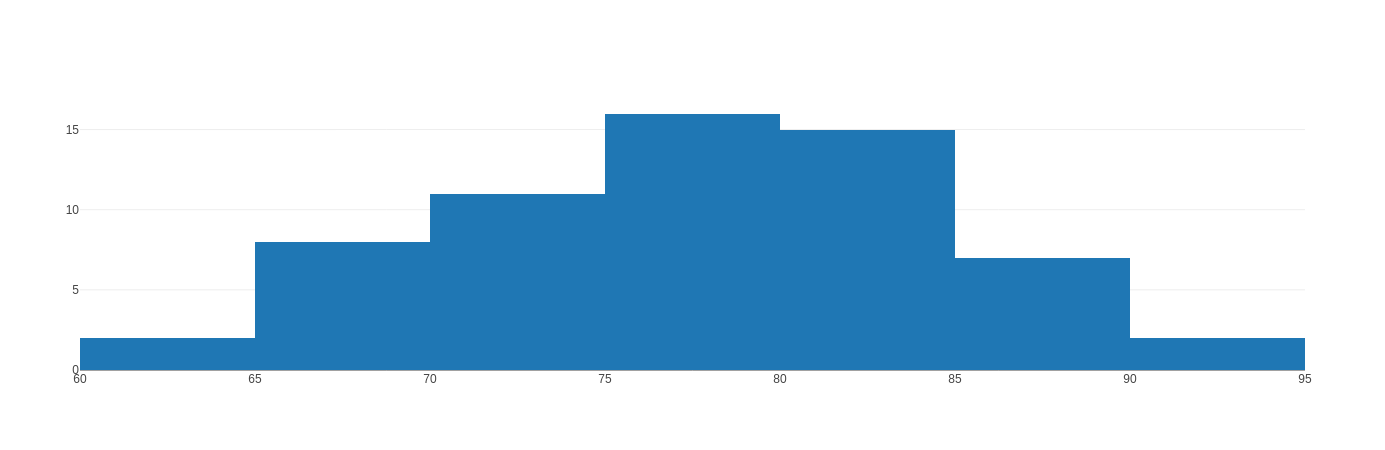

In [18]:
plotly.offline.iplot([go.Histogram(x=dataset_scores['sr'])])

#### Normalize dataset scores

In [34]:
normalized_dataset_scores = dataset_scores.copy()

for method in ['rs', 'rr', 're', 'sr', 'ew']:
    raw_scores = dataset_scores[[method]].values
    scores_scaled = MinMaxScaler().fit_transform(raw_scores)
    normalized_dataset_scores[method + '_normalized'] = (scores_scaled*100).round(1)
    
normalized_dataset_scores.sample(5)

,completeness,metadata,usability,rs,rr,re,sr,ew,rs_normalized,rr_normalized,re_normalized,sr_normalized,ew_normalized
dataset_name,,,,,,,,,,,,,
traffic-cameras,99.0,80.0,54.0,73.0,71.0,77.0,72.0,78.0,33.3,27.6,35.7,27.6,37.0
building-permits-green-roofs,91.5,100.0,62.0,78.0,77.0,83.0,77.5,84.5,50.0,48.3,57.1,46.6,61.1
marriage-licence-statistics,100.0,88.0,62.0,79.0,77.0,83.0,78.0,83.0,53.3,48.3,57.1,48.3,55.6
daily-shelter-occupancy,99.0,80.0,50.0,71.0,69.0,75.0,70.0,76.0,26.7,20.7,28.6,20.7,29.6
residential-front-yard-parking,100.0,92.0,75.0,86.0,85.0,88.0,86.0,89.0,76.7,75.9,75.0,75.9,77.8


##### Example: Visualizing normalized SR histogram

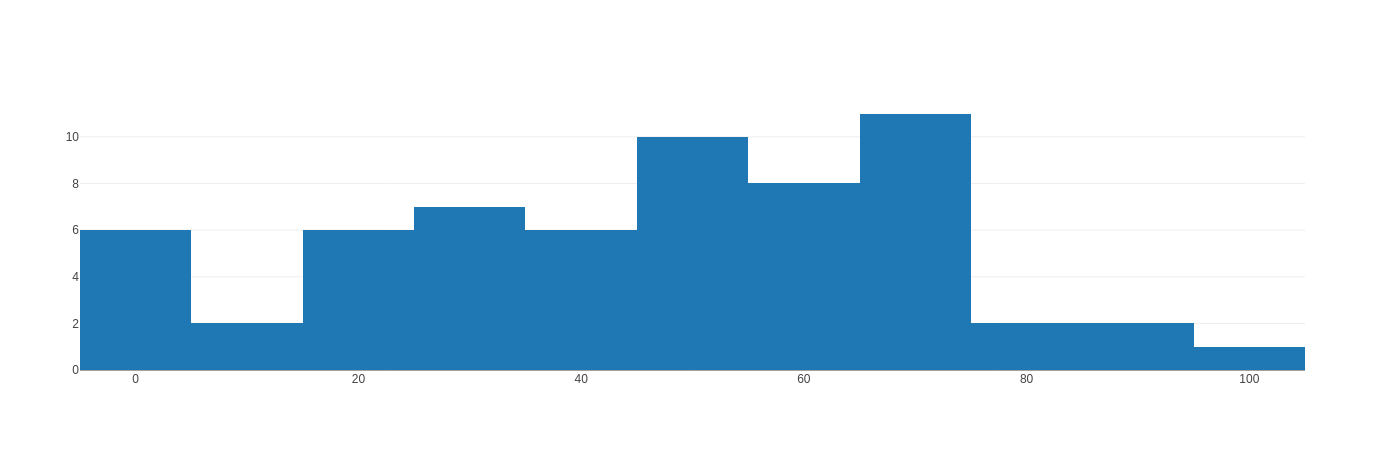

In [35]:
plotly.offline.iplot([go.Histogram(x=normalized_dataset_scores['sr_normalized'])])

### Bin into letter grades

**Note**: Grade ranges have to be reviewed. Illustration purposes only.

In [55]:
graded_dataset_scores = normalized_dataset_scores.copy()
cols = []

for method in ['rs', 'rr', 're', 'sr', 'ew']:
    column = method + '_grade'
    normal_column = method + '_normalized_grade'
    graded_dataset_scores[column] = pd.cut(dataset_scores[method], bins=[-1, 30, 50, 80, 100], labels=['D','C','B','A'])
    graded_dataset_scores[normal_column] = pd.cut(normalized_dataset_scores[method + '_normalized'], bins=[-1, 30, 50, 80, 100], labels=['D','C','B','A'])

    cols.extend([column, normal_column])
    
graded_dataset_scores = graded_dataset_scores[cols]
graded_dataset_scores.sample(5)

,rs_grade,rs_normalized_grade,rr_grade,rr_normalized_grade,re_grade,re_normalized_grade,sr_grade,sr_normalized_grade,ew_grade,ew_normalized_grade
dataset_name,,,,,,,,,,
bicycle-parking-high-capacity-outdoor,B,D,B,D,B,C,B,D,B,C
former-municipality-boundaries,B,C,B,C,A,C,B,C,A,B
street-furniture-poster-structure,A,B,A,B,A,B,A,B,A,A
marriage-licence-statistics,B,B,B,C,A,B,B,C,A,B
polls-conducted-by-the-city,B,B,B,B,A,B,B,B,A,B


In [92]:
dists = {}

for c in graded_dataset_scores.columns.values:
    dists[c] = graded_dataset_scores[c].reset_index(drop=False).groupby(c).count().to_dict()['dataset_name']

pd.DataFrame(dists)

,rs_grade,rs_normalized_grade,rr_grade,rr_normalized_grade,re_grade,re_normalized_grade,sr_grade,sr_normalized_grade,ew_grade,ew_normalized_grade
A,22,3,19,3,39,1,20,3,40,5
B,39,30,42,27,22,34,41,27,21,32
C,0,12,0,15,0,13,0,13,0,12
D,0,16,0,16,0,13,0,18,0,12


### Write to CKAN

In [ ]:
ckan_dev = ckanapi.RemoteCKAN( address='https://ckanadmin0.intra.dev-toronto.ca/', apikey='784f11cc-b170-4377-83a3-38ba28662b16')

In [ ]:
to_ckan = with_letter_grade.copy()
to_ckan['utc_timestamp'] = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
to_ckan['model'] = 'v1'

to_ckan.sample(frac=.2)

In [ ]:
ckan_dev.action.datastore_create(
    resource={
        'package_id': 'catalogue-scorecard',
        'name': 'Catalogue Scorecard',
        'format': 'CSV'
    },
    records=to_ckan.to_dict(orient='row')
)

In [ ]:
# ckan_dev.action.datastore_delete(id='1d4369aa-ff72-4b62-88a3-5043cd161715')

#### Reporting

In [ ]:
datasets_per_division = pd.DataFrame([ {'dataset_name': p['name'], 'title': p['title'], 'owner_division': p['owner_division'].strip() } for p in packages]).set_index('dataset_name')

In [ ]:
joined_df = datasets_per_division.join(with_letter_grade)
joined_df[[c for c in joined_df.columns.values if c != 'letter_grade']] = joined_df[[c for c in joined_df.columns.values if c != 'letter_grade']].fillna(0)
joined_df['letter_grade'] = joined_df['letter_grade'].cat.add_categories(['F'])
joined_df['letter_grade'] = joined_df['letter_grade'].fillna('F')
joined_df.sample(10)

In [ ]:
division_counts = joined_df.groupby(['owner_division', 'letter_grade'])['letter_grade'].count().unstack().fillna(0)
division_counts.sample(10)

In [ ]:
data = []

for i, l in enumerate(sorted(division_counts.columns.values)):
    data.append(
        go.Bar(
        x=division_counts.index.values,
        y=[ r[i] for r in division_counts.values],
        name=l
        )
    )

In [ ]:
fig = go.Figure(data=data, layout=go.Layout(barmode='group'))
plotly.offline.iplot(fig)

In [ ]:
fig = go.Figure(data=data, layout=go.Layout(barmode='stack'))
plotly.offline.iplot(fig)